<a href="https://colab.research.google.com/github/Nickchiu120026/2025_machine_learning/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch numpy matplotlib

Epoch     1 | train 0.158657 | val 0.141022
Epoch   200 | train 0.000020 | val 0.000023
Epoch   400 | train 0.000005 | val 0.000007
Epoch   600 | train 0.000010 | val 0.000008
Epoch   800 | train 0.000005 | val 0.000009
Epoch  1000 | train 0.000004 | val 0.000007
Epoch  1200 | train 0.000001 | val 0.000001
Epoch  1400 | train 0.000001 | val 0.000002
Epoch  1600 | train 0.000005 | val 0.000007
Epoch  1800 | train 0.000001 | val 0.000001
Early stopping at epoch 1817 (best val 0.000000)

== Final metrics on dense grid ==
MSE      : 0.00000041
Max Error: 0.00217503


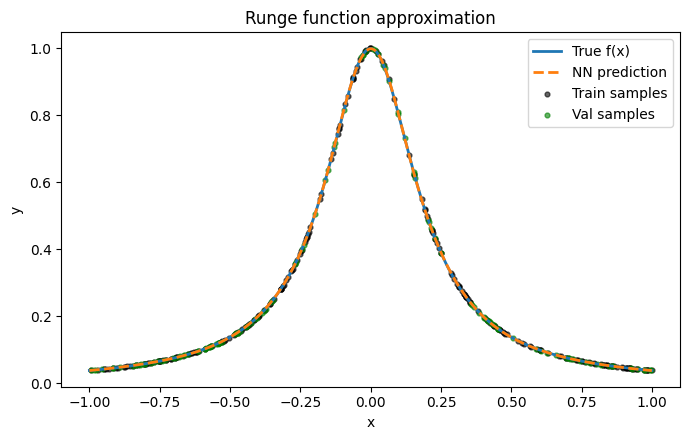

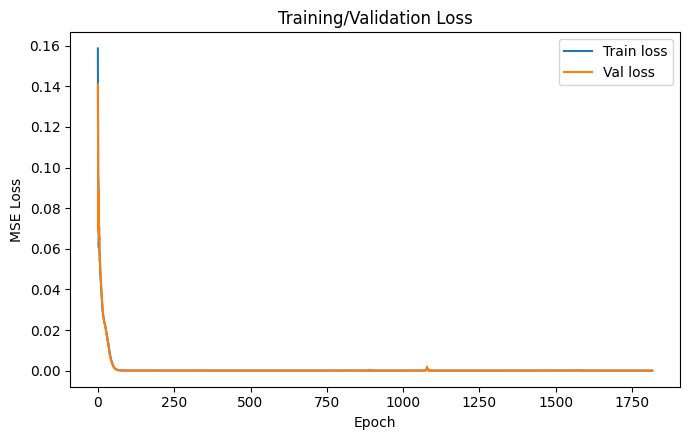


Suggested report bullets:
- Model: MLP (64, 64) with tanh activation, Adam lr=0.003, L2=1e-06
- Train points: 256, Val points: 128, Batch size: 64
- Best Val MSE: 0.00000037
- Test-grid MSE: 0.00000041, Max Error: 0.00217503


In [ ]:
import math
import random
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# -----------------------------
# 1. 基本設定與資料生成
# -----------------------------
SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def runge(x: np.ndarray) -> np.ndarray:
    """f(x) = 1 / (1 + 25 x^2)"""
    return 1.0 / (1.0 + 25.0 * x**2)

@dataclass
class Config:
    n_train: int = 256          # 訓練點數
    n_val: int = 128            # 驗證點數
    batch_size: int = 64
    lr: float = 3e-3
    epochs: int = 5000
    patience: int = 200         # early stopping
    hidden_sizes: tuple = (64, 64)  # MLP 隱藏層寬度
    act: str = "tanh"           # "tanh" 或 "relu"
    l2: float = 1e-6            # L2 正則化
    noise_std: float = 0.0      # 如果想模擬有雜訊的 y，可以改成 0.01

cfg = Config()

x_train = np.random.uniform(-1.0, 1.0, size=(cfg.n_train, 1)).astype(np.float32)
y_train = runge(x_train) + cfg.noise_std * np.random.randn(cfg.n_train, 1).astype(np.float32)

x_val = np.random.uniform(-1.0, 1.0, size=(cfg.n_val, 1)).astype(np.float32)
y_val = runge(x_val).astype(np.float32)

train_ds = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(x_val),   torch.from_numpy(y_val))
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False)

# -----------------------------
# 2. 建立模型
# -----------------------------
def make_mlp(input_dim=1, hidden_sizes=(64,64), act="tanh"):
    layers = []
    last = input_dim
    Act = nn.Tanh if act.lower() == "tanh" else nn.ReLU
    for h in hidden_sizes:
        layers += [nn.Linear(last, h), Act()]
        last = h
    layers += [nn.Linear(last, 1)]  # 輸出 1 維
    return nn.Sequential(*layers)

model = make_mlp(hidden_sizes=cfg.hidden_sizes, act=cfg.act).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.l2)

# -----------------------------
# 3. 訓練 + Early Stopping
# -----------------------------
best_val = float("inf")
best_state = None
hist_train = []
hist_val = []
no_improve = 0

for epoch in range(1, cfg.epochs + 1):
    # train
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)
    train_loss = running / len(train_ds)
    hist_train.append(train_loss)

    # validate
    model.eval()
    running = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            running += loss.item() * xb.size(0)
    val_loss = running / len(val_ds)
    hist_val.append(val_loss)

    # early stopping
    if val_loss + 1e-12 < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1

    if epoch % 200 == 0 or epoch == 1:
        print(f"Epoch {epoch:5d} | train {train_loss:.6f} | val {val_loss:.6f}")

    if no_improve >= cfg.patience:
        print(f"Early stopping at epoch {epoch} (best val {best_val:.6f})")
        break

if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# -----------------------------
# 4. 評估與繪圖
# -----------------------------
xs = np.linspace(-1.0, 1.0, 1000, dtype=np.float32).reshape(-1, 1)
ys = runge(xs)

model.eval()
with torch.no_grad():
    preds = model(torch.from_numpy(xs).to(device)).cpu().numpy()

mse = float(np.mean((preds - ys) ** 2))
max_err = float(np.max(np.abs(preds - ys)))
print(f"\n== Final metrics on dense grid ==")
print(f"MSE      : {mse:.8f}")
print(f"Max Error: {max_err:.8f}")

# 圖1
plt.figure(figsize=(7,4.5))
plt.plot(xs, ys, label="True f(x)", linewidth=2)
plt.plot(xs, preds, label="NN prediction", linewidth=2, linestyle="--")
plt.scatter(x_train, y_train, s=12, alpha=0.6, c="black", label="Train samples")
plt.scatter(x_val, y_val, s=12, alpha=0.6, c="green", label="Val samples")

plt.title("Runge function approximation")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.savefig("fig_fit.png", dpi=160)
plt.show()

# 圖2
plt.figure(figsize=(7,4.5))
plt.plot(hist_train, label="Train loss")
plt.plot(hist_val, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training/Validation Loss")
plt.legend()
plt.tight_layout()
plt.savefig("fig_loss.png", dpi=160)
plt.show()

# -----------------------------
# 5. 額外：匯出關鍵數據，方便寫報告
# -----------------------------
print("\nSuggested report bullets:")
print(f"- Model: MLP {cfg.hidden_sizes} with {cfg.act} activation, Adam lr={cfg.lr}, L2={cfg.l2}")
print(f"- Train points: {cfg.n_train}, Val points: {cfg.n_val}, Batch size: {cfg.batch_size}")
print(f"- Best Val MSE: {best_val:.8f}")
print(f"- Test-grid MSE: {mse:.8f}, Max Error: {max_err:.8f}")

